<a href="https://colab.research.google.com/github/cielcs/Super-resolution/blob/main/SRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## モデルの構築と学習<br/>
resolution_train.py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

170498071/170498071 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 32, 32, 64)           0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['activation[0][0]']          
                           

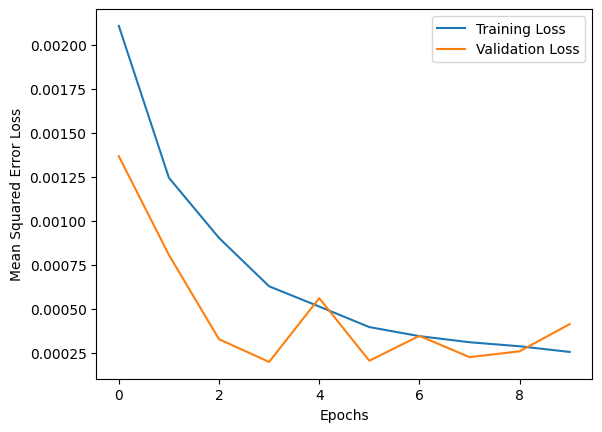

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

# データセットの読み込み
(train_lr_images, _), (test_lr_images, _) = cifar10.load_data()
# 低解像度画像を正規化
train_lr_images = train_lr_images.astype('float32') / 255.0
test_lr_images = test_lr_images.astype('float32') / 255.0

# 高解像度画像は低解像度画像を2倍にアップサンプリングして生成
train_hr_images = tf.image.resize(train_lr_images, size=(64, 64), method=tf.image.ResizeMethod.BILINEAR).numpy()
test_hr_images = tf.image.resize(test_lr_images, size=(64, 64), method=tf.image.ResizeMethod.BILINEAR).numpy()

# ディープラーニングモデルの構築
def build_sr_model():
    input_img = Input(shape=(32, 32, 3))  # 3はカラー画像のチャンネル数

    # Low-resolution feature extraction
    x = Conv2D(64, (3, 3), padding='same')(input_img)
    x = Activation('relu')(x)

    # Residual blocks
    for _ in range(16):
        x = residual_block(x)

    # High-resolution reconstruction
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)  # 2倍のアップサンプリング
    output_img = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)  # 3はカラー画像のチャンネル数

    model = Model(inputs=input_img, outputs=output_img)
    return model

# Residual block
def residual_block(x):
    filters = 64
    res = Conv2D(filters, (3, 3), padding='same')(x)
    res = BatchNormalization()(res)
    res = Activation('relu')(res)
    res = Conv2D(filters, (3, 3), padding='same')(res)
    res = BatchNormalization()(res)
    res = tf.keras.layers.add([res, x])  # Residual connection
    return res

# モデルの構築
sr_model = build_sr_model()

# モデルのコンパイル
sr_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# モデルのサマリー表示
sr_model.summary()

# モデルの訓練
history = sr_model.fit(train_lr_images, train_hr_images, epochs=10, batch_size=16, validation_split=0.2)


# モデルを保存するパス
model_save_path = '/content/drive/My Drive/sr_model.h5'

# モデルの保存
sr_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# 訓練の進捗をプロット
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.show()



## 評価するコード<br/>
resolution_valid.py

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

# データセットの読み込み
(_, _), (test_lr_images, _) = cifar10.load_data()

# 低解像度画像を正規化
test_lr_images = test_lr_images.astype('float32') / 255.0

# 高解像度画像はバイリニア補完で生成
test_hr_bilinear = tf.image.resize(test_lr_images, size=(64, 64), method=tf.image.ResizeMethod.BILINEAR)

# モデルを読み込む
model_path = '/content/drive/My Drive/sr_model.h5'
loaded_model = load_model(model_path)

# 読み込んだモデルのサマリーを表示
loaded_model.summary()

# テストデータから高解像度画像を生成
test_hr_predicted = loaded_model.predict(test_lr_images)

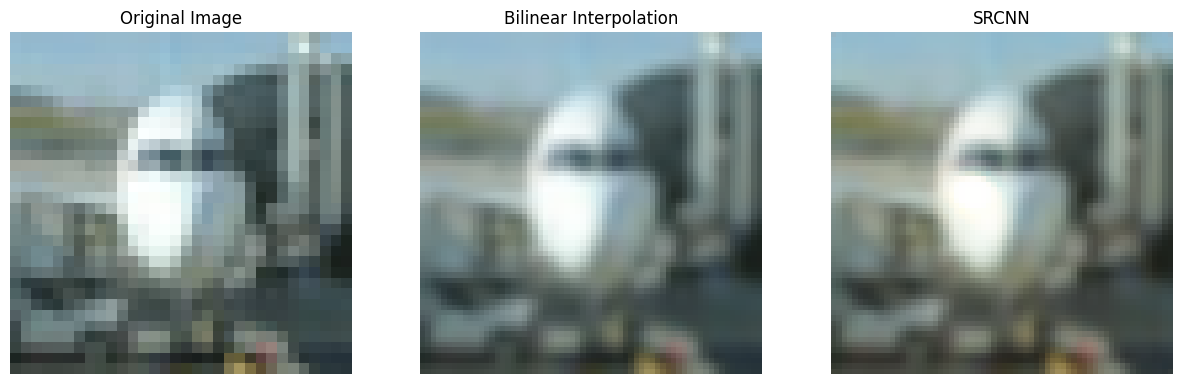

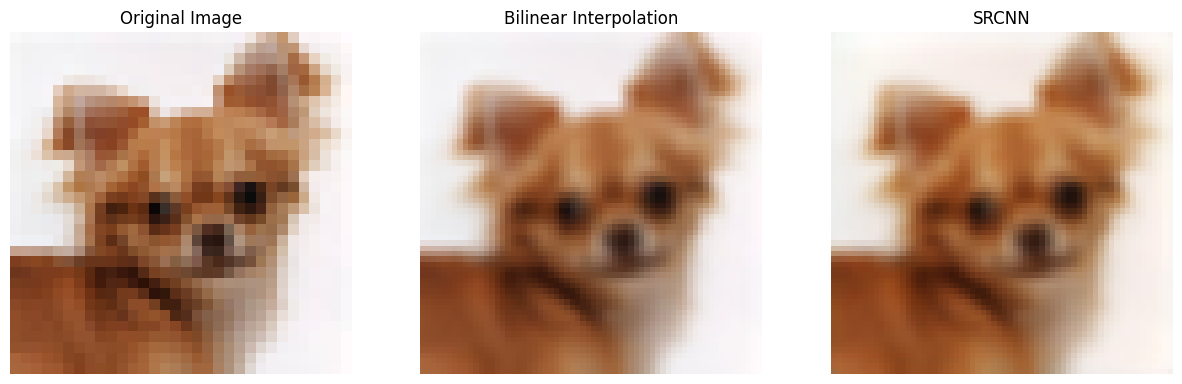

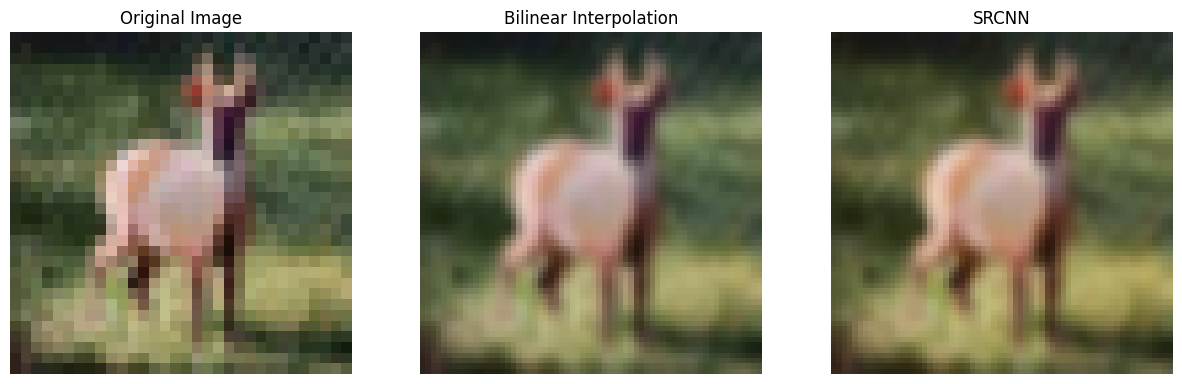

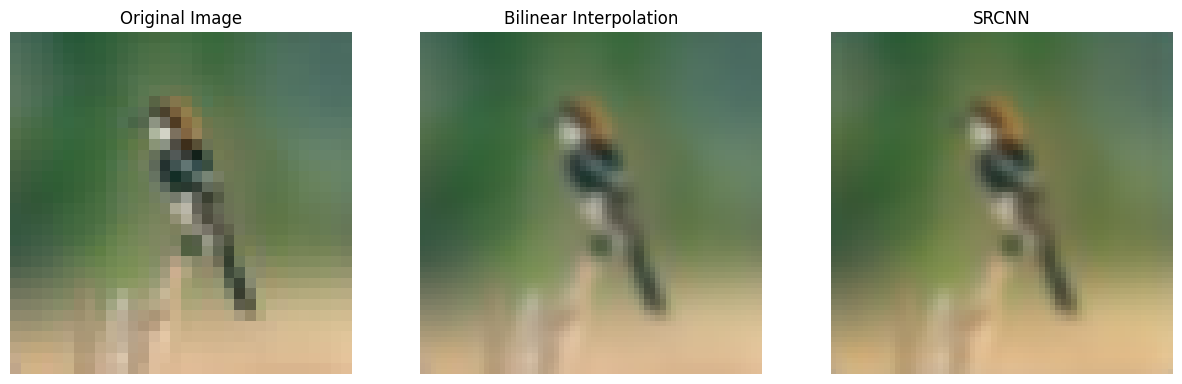

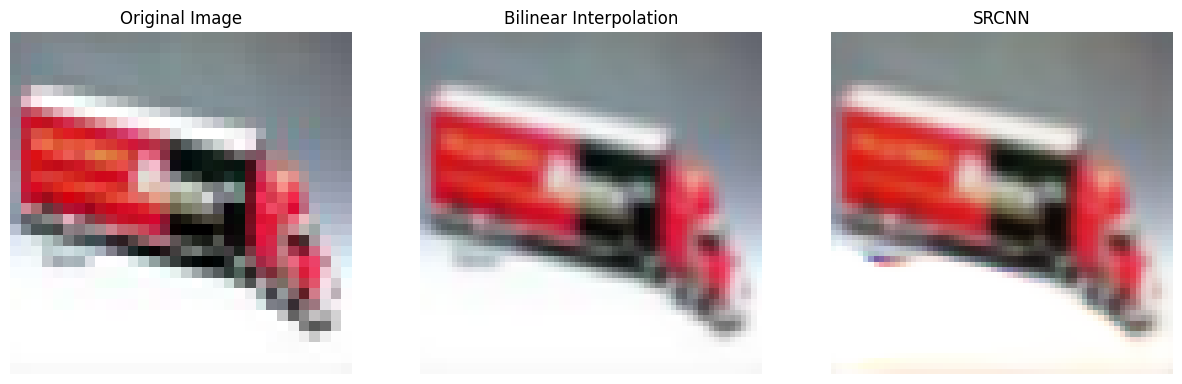

In [17]:
def plot_images(original, bilinear, predicted):
    plt.figure(figsize=(15, 5))

    # 元の画像
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original)
    plt.axis('off')

    # バイリニア補完による画像
    plt.subplot(1, 3, 2)
    plt.title("Bilinear Interpolation")
    plt.imshow(bilinear)
    plt.axis('off')

    # SRCNNによる生成画像
    plt.subplot(1, 3, 3)
    plt.title("SRCNN")
    plt.imshow(predicted)
    plt.axis('off')

    plt.show()

# 4枚のテスト画像を処理してプロット
for i in range(5):
    r=int(np.random.normal(0,500))
    original_image = test_lr_images[r]
    bilinear_image = test_hr_bilinear[r]
    predicted_image = test_hr_predicted[r]

    plot_images(original_image, bilinear_image, predicted_image)


## 三つの補完アルゴリズム比較

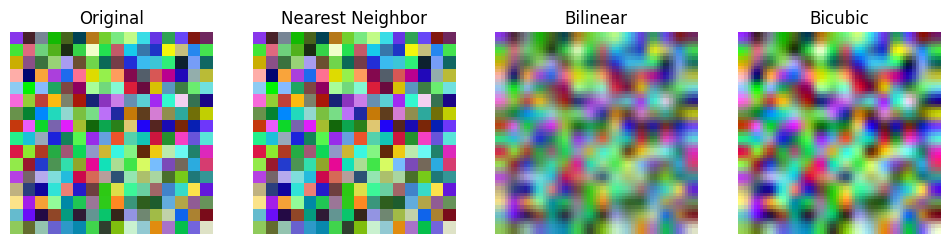

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# サンプル画像の生成
train_lr_images = tf.random.uniform(shape=[1, 16, 16, 3], minval=0, maxval=255, dtype=tf.float32)  # 低解像度のランダム画像

# 各種補間方法でリサイズ
nearest = tf.image.resize(train_lr_images, size=(64, 64), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR).numpy()
bilinear = tf.image.resize(train_lr_images, size=(64, 64), method=tf.image.ResizeMethod.BILINEAR).numpy()
bicubic = tf.image.resize(train_lr_images, size=(64, 64), method=tf.image.ResizeMethod.BICUBIC).numpy()

# 結果のプロット
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.title("Original")
plt.imshow(train_lr_images[0] / 255.0)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Nearest Neighbor")
plt.imshow(nearest[0] / 255.0)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Bilinear")
plt.imshow(bilinear[0] / 255.0)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Bicubic")
plt.imshow(bicubic[0] / 255.0)
plt.axis('off')

plt.show()
